### 6.6.1 卷积神经网络 LeNet
总体来看，LeNet（LeNet-5）由两个部分组成：
- 卷积编码器：由两个卷积层组成;
- 全连接层密集块：由三个全连接层组成。
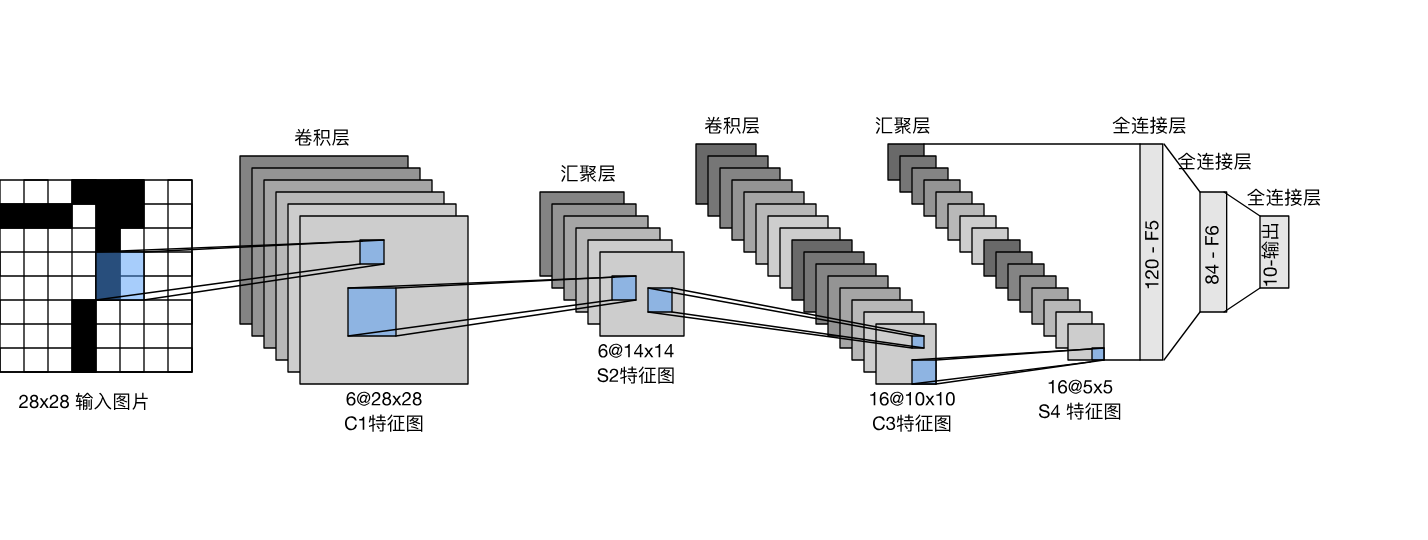

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
###6.6.2 模型训练
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [5]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.415, train acc 0.847, test acc 0.828
107048.0 examples/sec on cuda:0


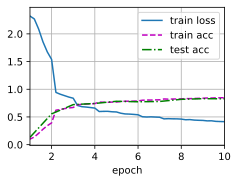

In [11]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 6.6.4 练习
1. 将平均汇聚层替换为最大汇聚层，会发生什么？
2. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    2. 调整输出通道的数量。
    3. 调整激活函数（如ReLU）。
    4. 调整卷积层的数量。
    5. 调整全连接层的数量。
    6. 调整学习率和其他训练细节（例如，初始化和轮数）。
3. 在MNIST数据集上尝试上述改进的网络。
4. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

In [ ]:
# 1. 将平均汇聚层替换为最大汇聚层
net_maxpool = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

# 2. 构建一个更复杂的网络
net_complex = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256 * 7 * 7, 512), nn.ReLU(),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 10))

# 3. 在MNIST数据集上尝试上述改进的网络
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.05, 10
train_ch6(net_maxpool, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
train_ch6(net_complex, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 4. 显示不同输入时，LeNet第一层和第二层的激活值
def show_activations(net, X):
    activations = []
    for layer in net:
        X = layer(X)
        if isinstance(layer, nn.Conv2d):
            activations.append(X)
    return activations

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
activations = show_activations(net, X)

# 可视化激活值
import matplotlib.pyplot as plt

def plot_activations(activations, title):
    fig, axes = plt.subplots(1, len(activations), figsize=(15, 15))
    for i, activation in enumerate(activations):
        axes[i].imshow(activation[0, 0].detach().numpy(), cmap='viridis')
        axes[i].set_title(f'{title} Layer {i+1}')
    plt.show()

plot_activations(activations, 'LeNet')